# Overview of Noise Sources

Use this notebook to check the properties of the noise. The next few cells just contain a couple of convenience functions and <a href="#$1/f^{\alpha}$-Power-Law-Noise">you can skip directly to the content below</a>. 

You should have at least 8 GB of RAM if you want to run the whole notebook because all noise streams are kept in memory for analysis. The data rates below were measured on my old Intel Core i5-4690 CPU.

In [1]:
%matplotlib inline
import pyplnoise
import time
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

In [2]:
def autocorr(x):
    corr_raw = scipy.signal.fftconvolve(x, x[::-1], mode='full')
    corr_raw = corr_raw[corr_raw.size//2:]
    # scale the result to get an unbiased estimate
    result = np.divide(corr_raw, corr_raw.size - np.arange(0, corr_raw.size, 1))
    return result
def plot_welch_and_autocorr(x, fs, nperseg=250000, ac_lag_max=6000):
    ac = autocorr(x)
    f, S_f = scipy.signal.welch(x, fs=fs, nperseg=nperseg,
                                scaling='density', return_onesided=False,
                                detrend='constant')
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle("Welch Periodogram & Autocorrelation")
    axs[0].grid(True)
    axs[0].loglog(f[2:f.size//2], S_f[2:f.size//2])
    axs[0].set_xlabel("f (Hz)")
    axs[0].set_ylabel("Two-sided power spectral density (unit$^2$/Hz)")
    axs[1].plot(ac[0:ac_lag_max])
    axs[1].grid(True)
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position('right')
    axs[1].set_xlabel("Lag $j$")
    axs[1].set_ylabel("Autocorrelation $<x_{i}x_{i-j}>$")
    return (fig, axs)
def plot_time_series_and_histogram(t, x):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle("Time series & Histogram")
    axs[0].grid(True)
    axs[0].plot(t/3600., x)
    axs[0].set_xlabel("Time (h)")
    axs[0].set_ylabel("Signal (a.u.)")
    n, bins, _ = axs[1].hist(x, 40)
    axs[1].plot(bins, n.max()*np.exp(-(bins-x.mean())**2./(2.*x.std()**2.)))
    axs[1].grid(True)
    axs[1].yaxis.tick_right()
    axs[1].yaxis.set_label_position('right')
    axs[1].set_xlabel("Signal (a.u.)")
    axs[1].set_ylabel("# Samples")
    return (fig, axs)

In [3]:
fs = 100.
npts = 60000000
t = np.linspace(0., npts/fs, num=npts)

##  General $1/f^{\alpha}$ Power Law Noise

Parameters $\alpha=1.5$, $f_{min} = 10^{-2}\text{ Hz}$, $f_{max} = 10\text{ Hz}$. As you can see, the noise becomes white below $f_{min}$ and above $f_{max}$.

In [4]:
plnoise = pyplnoise.AlphaNoise(fs, 1e-2, 10., alpha=1.5)
t0 = time.time()
x_pl = plnoise.get_series(npts)
t1 = time.time()
print("Data rate: {:g} samples/sec".format(npts/(t1 - t0)))

Data rate: 4.91677e+06 samples/sec


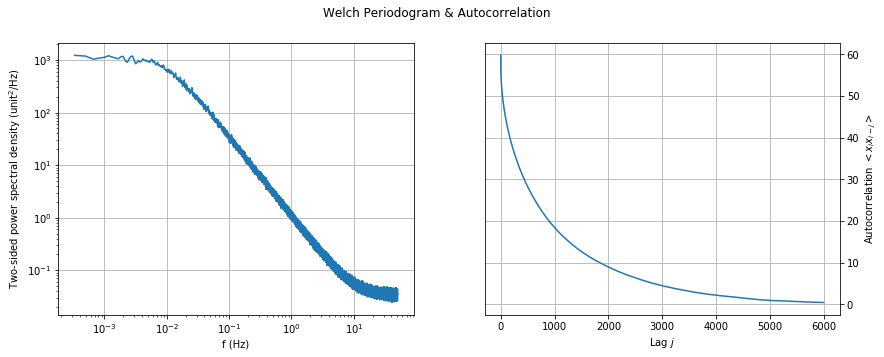

In [5]:
fig, axs = plot_welch_and_autocorr(x_pl, fs, nperseg=600000)

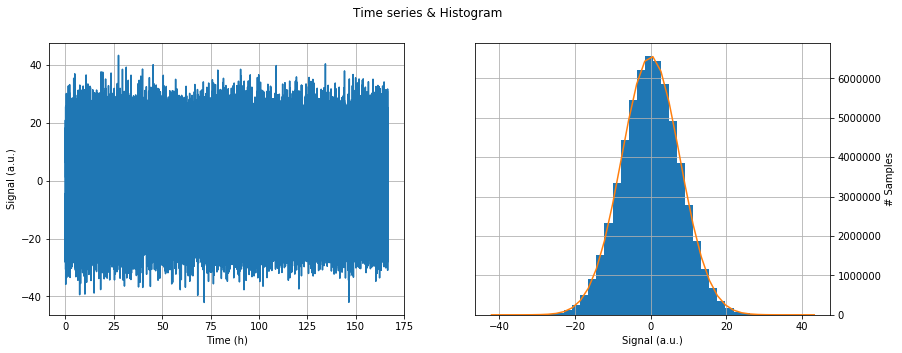

In [6]:
fig, axs = plot_time_series_and_histogram(t, x_pl)

## Pink Noise

A convenience alias is provided for the special case $\alpha=1.0$. Here: $f_{min} = 10^{-2}\text{ Hz}$, $f_{max} = 50\text{ Hz}$.

In [7]:
pknoise = pyplnoise.PinkNoise(fs, 1e-2, 50.)
x_pk = pknoise.get_series(npts)

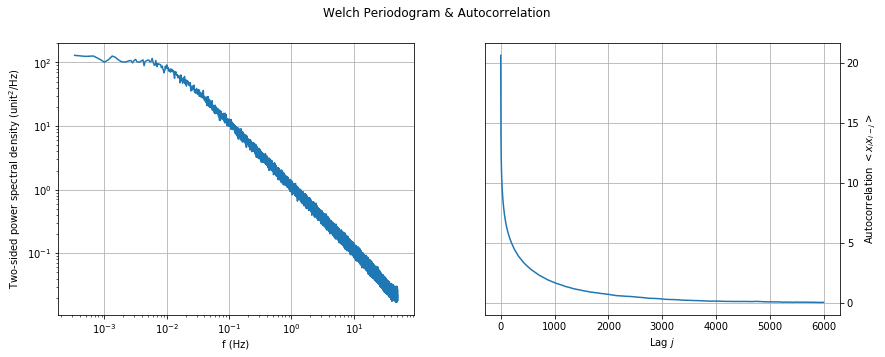

In [8]:
fig, axs = plot_welch_and_autocorr(x_pk, fs, nperseg=600000)

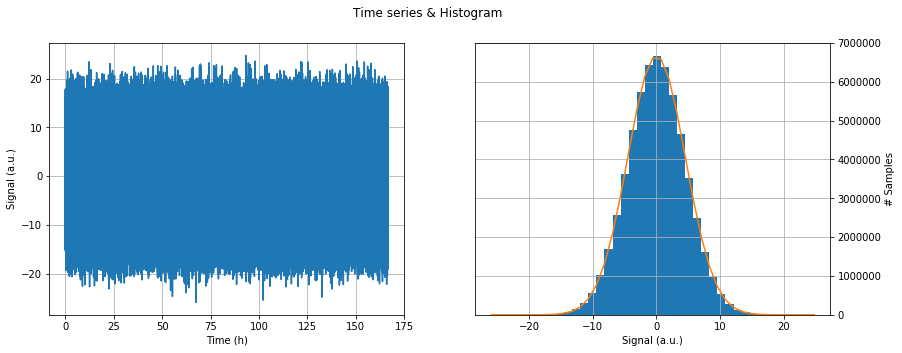

In [9]:
fig, axs = plot_time_series_and_histogram(t, x_pk)

## Red Noise

Parameter $f_{min} = 10^{-2}\text{ Hz}$. If you also like to adjust an upper frequency limit, use ``AlphaNoise`` with $\alpha = 2.0$ (note however that ``AlphaNoise`` is slower than the ``RedNoise`` class).

In [10]:
rdnoise = pyplnoise.RedNoise(fs, 1e-2)
t0 = time.time()
x_rd = rdnoise.get_series(npts)
t1 = time.time()
print("Data rate: {:g} samples/sec".format(npts/(t1 - t0)))

Data rate: 2.46153e+07 samples/sec


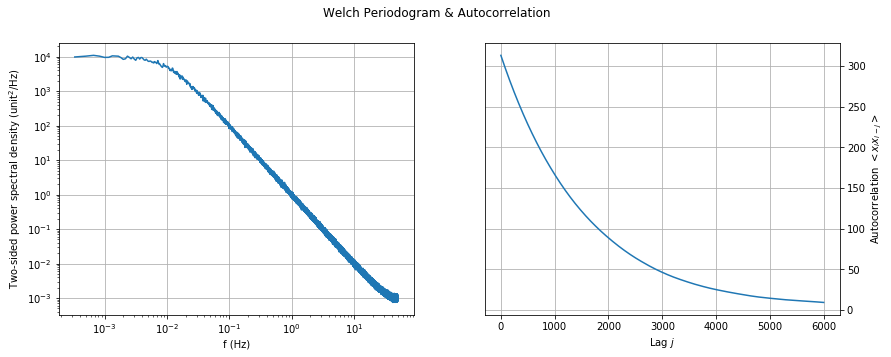

In [11]:
fig, axs = plot_welch_and_autocorr(x_rd, fs, nperseg=600000)

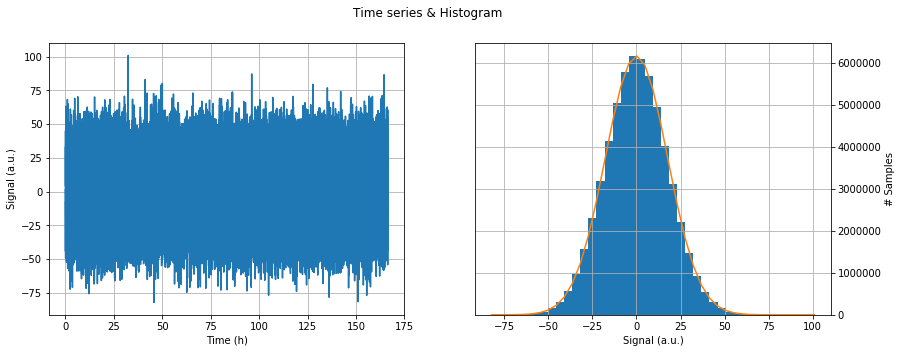

In [12]:
fig, axs = plot_time_series_and_histogram(t, x_rd)

## White Noise

White noise is the basis for everything and is generated using NumPy's default random number generator. Starting with NumPy version 1.17, it is of the family of <a href="http://www.pcg-random.org">"permuted congruential generators"</a>.

In [13]:
whnoise = pyplnoise.WhiteNoise(fs, psd=1.0)
t0 = time.time()
x_wh = whnoise.get_series(npts)
t1 = time.time()
print("Data rate: {:g} samples/sec".format(npts/(t1 - t0)))

Data rate: 4.98695e+07 samples/sec


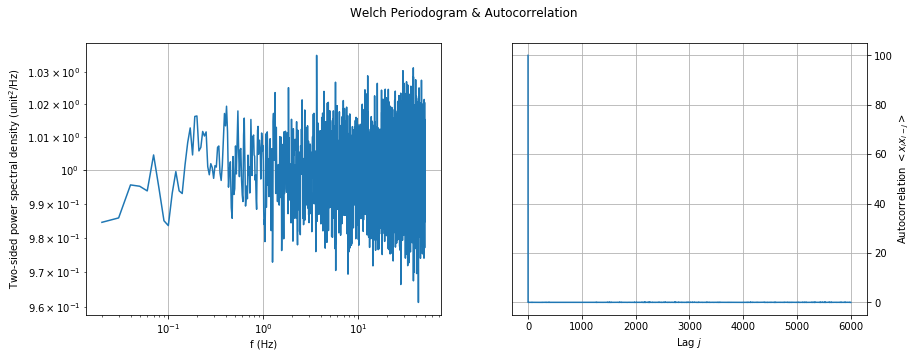

In [14]:
fig, axs = plot_welch_and_autocorr(x_wh, fs, nperseg=10000)

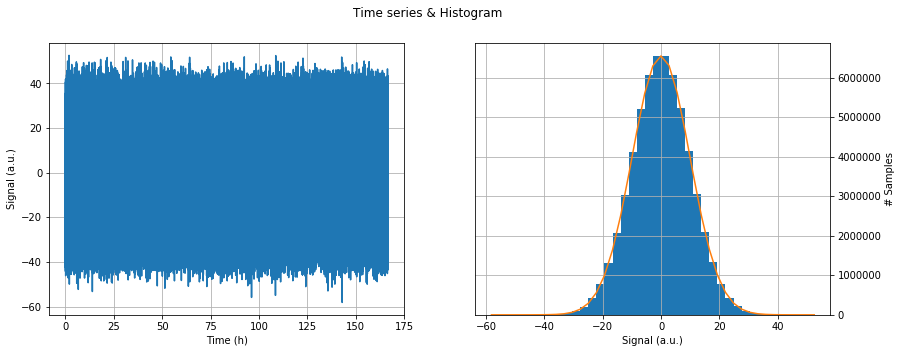

In [15]:
fig, axs = plot_time_series_and_histogram(t, x_wh)